#Global Imports

In [ ]:
# Imports to be used throughout the document

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function imports for use in one specific cell will be called in that cell

#What is this dataset?

This dataset describes the rail infrastructure and use of the LUAS. This data can be grouped by line to compare between the two LUAS lines (Red and Green lines), and it can be grouped by year to compare time-trends.

This infrastructure is described using key metrics:

  -Number of trams in use, Tram model lengths and capacities, Line lengths and journey times, Total tram mileages, and Service timeliness.

The use of the LUAS is described using key metrics:

  -Total passenger usages, Total passenger mileage, and Average length and #stops of passengers

In [ ]:
# data.cso.ie
# Home / Transport / Transport Hub / TOA10 - Luas infrastructure

df = pd.read_csv("TOA10_CSO.csv")

print("Readout of the first ten rows of data, raw format: ")
print("\n")
print(df[:10]) #Raw printout, no preprocessing
print("\n")
print("Key metrics:")
print("\n")
print(*np.unique(df["Statistic Label"]),sep="\n")

Readout of the first ten rows of data, raw format: 


  Statistic Label  Year   Luas Line UNIT  VALUE
0  Length of line  2018    Red line   km   20.5
1  Length of line  2018  Green line   km   22.0
2  Length of line  2019    Red line   km    NaN
3  Length of line  2019  Green line   km    NaN
4  Length of line  2020    Red line   km    NaN
5  Length of line  2020  Green line   km    NaN
6  Length of line  2021    Red line   km   20.8
7  Length of line  2021  Green line   km   22.0
8  Length of line  2022    Red line   km   20.8
9  Length of line  2022  Green line   km   22.0


Key metrics:


Average length of journey
Average number of stops per passenger
Capacity of tram
Journey time
Length of line
Length of tram
Passenger kilometres
Passengers carried
Timeliness (% services to timetable)
Trams
Vehicle kilometres


#Pertinent LUAS-related issues

**Infrastructure efficiency and degradation over time**

Transport demands are not static. It is thus important to identify aspects of transport infrastructure that excell, and those that require, or may in future require, additional infrastructure. This can be examined with the dataset specifically by LUAS line, per year.

**The theoretical bandwidth of the LUAS**

What is the peak load of the LUAS service? This problem may arise due to special occasions such as match days, etc. For instance, at the time of writing there will be three large events taking place in Dublin on the 22nd/Nov/2025 - two large music concerts, and a large sporting event.

While that is specific to a singularity (one day), there are instances where a high load demand may be spread across weaks or months (for example: hosting Euro2028, hosting a Rugby World Cup, national commemorative events such as 1916-2016, etc.). Knowing the total load the LUAS may offer as service for events or indeed multi-events is important for city-wide planning (e.g.: road closures, Garda prescence).

If Ireland is to apply/organise to host any major events in Dublin, generating these figures as part of the tender process is imperative.

**The quality of service (QoS)**

This dataset may offer some metrics (such as service timeliness, journey time, length) that can determine some aspects of the overall LUAS QoS. The importance of QoS in relation to passenger uptake can be related and examined.



#Preprocessing

In [ ]:
# Sort by year beginning with 2024 down to 2018. Also instate this as the new index
df = df.sort_values(by=["Year"],ascending=False,ignore_index=True)

In [ ]:

# This function checks that each column has consistent datatype entries:

def checktype(df,col):
  unique_entries = np.unique(df[col])
  unique_list = []

  for entry in unique_entries:
    unique_list.append(type(entry)) #append type of each unique entry

  unique_types = set(unique_list) #unique type(s) of every unique entry

  return unique_types


# Checking every column:

print("\n")
print("Unique datatypes for each column:")
print("\n")

for column in df:
  print(checktype(df,column))



Unique datatypes for each column:


{<class 'str'>}
{<class 'numpy.int64'>}
{<class 'str'>}
{<class 'str'>}
{<class 'numpy.float64'>}


In [ ]:
# Applying more suitable names and common syntax to the metadata available:

print("Before:")
print(*df.columns,sep=",") #show current column heads "Statistic Label,Year,Luas Line,UNIT,VALUE"
print("\n")

df = df.rename(columns={"Statistic Label":"Metric","Luas Line":"Line","UNIT":"Unit","VALUE":"Value"})

print("After:")
print(*df.columns,sep=",")

Before:
Statistic Label,Year,Luas Line,UNIT,VALUE


After:
Metric,Year,Line,Unit,Value


In [ ]:
# Rename some of the units from the Unit column to keep common syntax:

print("Before:")
print(*np.unique(df["Unit"]),sep=",") #show current units "%,Metres,Minutes,Number,km"
print("\n")

df["Unit"] = df["Unit"].replace({"km":"Kilometre","%":"Percentage"})

print("After:")
print(np.unique(df["Unit"]))


# NOTE:

# I do appreciate that the "Number" unit may be interpreted as degenerate: "Number" can refer to number of trams, or passenger capacity on each tram, or total passengers
# carried per annum, etc. But for this preprocessing I will leave it intact and consider "Number" to be an encompassing scalar quantity unit. I also note, from this decision,
# I'm not going to re-name every "Number" instance to "Scalar Quantity" because I think it is uneccessarily mathematical and pedantic.
# df["Unit"] = df["Unit"].replace({"Number":"Scalar Quantity"}) # but you could do it as such


Before:
%,Metres,Minutes,Number,km


After:
['Kilometre' 'Metres' 'Minutes' 'Number' 'Percentage']


In [ ]:
# DATA TYPE CHECKS: check every entry is the expected type

# Find empty/NaN cells:
print("Number of NaN values in each column:")
print("\n")
print(df.isnull().sum()) #yields 8 NaN entries in col=Value

print("\n")

print("Empty string entries in each column:")
print("\n")
print(df.eq("").sum()) #yeilds no empty strings

null_value_rows = df[df["Value"].isnull()]
print("\n")
print("Rows with null values:")
print(null_value_rows.index) #they occur on rows 88, 89, 110, 111, 124, 142

Number of NaN values in each column:


Metric    0
Year      0
Line      0
Unit      0
Value     8
dtype: int64


Empty string entries in each column:


Metric    0
Year      0
Line      0
Unit      0
Value     0
dtype: int64


Rows with null values:
Index([88, 89, 110, 111, 118, 124, 142, 145], dtype='int64')


In [ ]:
# I was unable to find a data-driven, automatic way to deal with the NaN types, so manual wrangling is done:

# The lengths of lines "Value" entry is formatted as "22.0km" and "20.8km" for the green and red lines respectively in the years 2020 and 2019. This is manually changed:

df.loc[(df["Metric"]=="Length of line") & (df["Year"].isin([2019, 2020])) & (df["Line"]=="Green line"), "Value"] = 22.0 #km
df.loc[(df["Metric"]=="Length of line") & (df["Year"].isin([2019, 2020])) & (df["Line"]=="Red line"), "Value"] = 20.8 #km

# In 2018 and 2019, the Green line trams were a mixture of 43.6m and 54.7m length trams while the rolling stock was being replaced.
# In this wrangling, the average Length and Capacity of the two tram models will be taken, so (43.6+54.7)/2 = 49.15m, and same treatment for capacity.
# This was chosen as the best representation of the stock for each year. Another alternative for perhaps more cohesive yearly trend review would be to take 2018 as just the lower
# stock, and 2019 as the larger stock:

df.loc[(df["Metric"]=="Length of tram") & (df["Year"].isin([2018,2019])) & (df["Line"]=="Green line"), "Value"] = 49.15 #(43.6+54.7)/2 = 49.15m

df.loc[(df["Metric"]=="Capacity of tram") & (df["Year"]==2018) & (df["Line"]=="Green line"), "Value"] = 327 # (287+367)/2 = 327 passengers
df.loc[(df["Metric"]=="Capacity of tram") & (df["Year"]==2019) & (df["Line"]=="Green line"), "Value"] = 364 #(319+408)/2 = 363.5 ~ 364 passengers


null_value_rows = df[df["Value"].isnull()]
print("Rows with null values (should be an empty set now):")
print(null_value_rows.index)



Rows with null values (should be an empty set now):
Index([], dtype='int64')


In [ ]:
# I want to also make a new column based on line bandwidth
# total bandwidth = regular load + extraordinary loads

# total bandwidth:
# pertinent: {capacity of tram, trams}
# can also use vehicle kilometres/length of line = total vehicle runs
# total vehicle runs * capacity of tram = maximum theoretical bandwidth per annum


# Load factor = (Passengers carried)/(Theoretical annual capacity)

In [ ]:
# NEW COLUMN: ~ TOTAL TRAM VEHICLE TRIPS/RUNS P.A. - (Vehicle kilometres)/(Length of line)


new_rows = []

for year in df["Year"].unique():

  for line in df["Line"].unique():

    vehicle_km_value = df[(df["Metric"]=="Vehicle kilometres") & (df["Year"] == year) & (df["Line"] == line)]["Value"].values
    line_length_value = df[(df["Metric"]=="Length of line") & (df["Year"] == year) & (df["Line"] == line)]["Value"].values

    total_vehicle_runs = vehicle_km_value[0] / line_length_value[0] #[km/km].. "unitless" scalar => "Unit":"Number"

    new_rows.append({"Metric":"Total vehicle runs","Year":year,"Line":line,
                      "Unit":"Number","Value":int(total_vehicle_runs)})

# Filler dataframe with the new rows to help concatenate with df
df_total_vehicle_runs = pd.DataFrame(new_rows)

# Concatneate w/ the original df
df = pd.concat([df, df_total_vehicle_runs], ignore_index=True)

# Re-sort the df
df = df.sort_values(by=["Year", "Line", "Metric"], ascending=[False, True, True], ignore_index=True)

print("Header of new total vehicle runs metric:")
print("\n")
print(df[df["Metric"] == "Total vehicle runs"].head())

Header of new total vehicle runs metric:


                Metric  Year        Line    Unit     Value
9   Total vehicle runs  2024  Green line  Number   95033.0
21  Total vehicle runs  2024    Red line  Number  110876.0
33  Total vehicle runs  2023  Green line  Number   93606.0
45  Total vehicle runs  2023    Red line  Number  108427.0
57  Total vehicle runs  2022  Green line  Number   96592.0


In [ ]:
# NEW COLUMN: PASSENGERS PER TRAM SERVICE RUN
# Will allow to give an idea of how much usage on average each service gets

new_rows_passengers_per_run = []

for year in df["Year"].unique():

  for line in df["Line"].unique():

    passengers = df[(df["Metric"]=="Passengers carried") & (df["Year"]==year) & (df["Line"]==line)]["Value"].values[0]
    tot_runs = df[(df["Metric"]=="Total vehicle runs") & (df["Year"]==year) & (df["Line"]==line)]["Value"].values[0]

    passengers_per_run = passengers/tot_runs #[passenger/run] ... "Unit":"Number"

    new_rows_passengers_per_run.append({"Metric":"Average passengers per run", "Year":year, "Line":line, "Unit":"Number", "Value":int(passengers_per_run)}) #round to whole number

# helper dataframe
df_passengers_per_run = pd.DataFrame(new_rows_passengers_per_run)

# Concatenate helper to df
df = pd.concat([df, df_passengers_per_run], ignore_index=True)

# Resort again
df = df.sort_values(by=["Year","Line","Metric"], ascending=[False,True,True], ignore_index=True)

print("Verify avg passgrs per run has generated:")
print("\n")
print(df[df["Metric"]=="Average passengers per run"].head(30))

Verify avg passgrs per run has generated:


                         Metric  Year        Line    Unit  Value
2    Average passengers per run  2024  Green line  Number  269.0
15   Average passengers per run  2024    Red line  Number  258.0
28   Average passengers per run  2023  Green line  Number  243.0
41   Average passengers per run  2023    Red line  Number  234.0
54   Average passengers per run  2022  Green line  Number  190.0
67   Average passengers per run  2022    Red line  Number  200.0
80   Average passengers per run  2021  Green line  Number  100.0
93   Average passengers per run  2021    Red line  Number   99.0
106  Average passengers per run  2020  Green line  Number  103.0
119  Average passengers per run  2020    Red line  Number   87.0
132  Average passengers per run  2019  Green line  Number  275.0
145  Average passengers per run  2019    Red line  Number  210.0
158  Average passengers per run  2018  Green line  Number  226.0
171  Average passengers per run  2018    Red l

#Data analysis

In [ ]:
print("Dataset information:")
print("\n")
df.info()
print("\n")
print("Full 2024 year data head. This cycle is repeated for each year back to 2018:")
print("\n")
df.head(28)

Dataset information:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Metric  182 non-null    object 
 1   Year    182 non-null    int64  
 2   Line    182 non-null    object 
 3   Unit    182 non-null    object 
 4   Value   182 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 7.2+ KB


Full 2024 year data head. This cycle is repeated for each year back to 2018:




,Metric,Year,Line,Unit,Value
0,Average length of journey,2024,Green line,Kilometre,5.920000e+00
1,Average number of stops per passenger,2024,Green line,Number,9.000000e+00
2,Average passengers per run,2024,Green line,Number,2.690000e+02
3,Capacity of tram,2024,Green line,Number,3.670000e+02
4,Journey time,2024,Green line,Minutes,6.600000e+01
5,Length of line,2024,Green line,Kilometre,2.200000e+01
6,Length of tram,2024,Green line,Metres,5.470000e+01
7,Passenger kilometres,2024,Green line,Kilometre,1.515929e+08
8,Passengers carried,2024,Green line,Number,2.560690e+07
9,Timeliness (% services to timetable),2024,Green line,Percentage,9.873000e+01


In [ ]:
# GENERATE SOME GENERAL METRICS:


#extract Metric for Year,Value comparison template:
#metric = df.loc[(df["Metric"]=="metric") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)


# Compare the annual ridership trend 2018-2024 for both lines:
passengers_per_annum_red = df.loc[(df["Metric"]=="Passengers carried") & (df["Line"]=="Red line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)
passengers_per_annum_green = df.loc[(df["Metric"]=="Passengers carried") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)

print("Red Line Annual Passenger Count:")
print(passengers_per_annum_red)
print("\n")
print("Green Line Annual Passenger Count:")
print(passengers_per_annum_green)
print("\n")

# Compare the average journey length 2018-2024 for both lines:
avg_journey_length_red = df.loc[(df["Metric"]=="Average length of journey") & (df["Line"]=="Red line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)
avg_journey_length_green = df.loc[(df["Metric"]=="Average length of journey") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)

print("Average journey length on the Red line [km]:")
print(avg_journey_length_red)
print("\n")
print("Average journey length on the Green line [km]:")
print(avg_journey_length_green)
print("\n")

# Service punctuality by line per year:
timeliness_red = df.loc[(df["Metric"]=="Timeliness (% services to timetable)") & (df["Line"]=="Red line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)
timeliness_green = df.loc[(df["Metric"]=="Timeliness (% services to timetable)") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)

print("Punctuality of the Red line service 2018-2024: [%]")
print(timeliness_red)
print("\n")
print("Punctuality of the Green line service 2018-2024: [%]")
print(timeliness_green)



Red Line Annual Passenger Count:
     Year       Value
177  2018  21837268.0
151  2019  24045744.0
125  2020   9727187.0
99   2021  10040293.0
73   2022  20275075.0
47   2023  25393165.0
21   2024  28620698.0


Green Line Annual Passenger Count:
     Year       Value
164  2018  19999700.0
138  2019  24301487.0
112  2020   9448869.0
86   2021   9441025.0
60   2022  18392800.0
34   2023  22812052.0
8    2024  25606901.0


Average journey length on the Red line [km]:
     Year  Value
169  2018   4.45
143  2019   4.50
117  2020   4.50
91   2021   4.50
65   2022   5.04
39   2023   4.20
13   2024   4.70


Average journey length on the Green line [km]:
     Year  Value
156  2018   8.10
130  2019   8.10
104  2020   8.10
78   2021   8.10
52   2022   4.40
26   2023   4.90
0    2024   5.92


Punctuality of the Red line service 2018-2024: [%]
     Year  Value
178  2018  97.05
152  2019  97.51
126  2020  97.51
100  2021  92.05
74   2022  90.73
48   2023  96.21
22   2024  97.56


Punctuality of the 

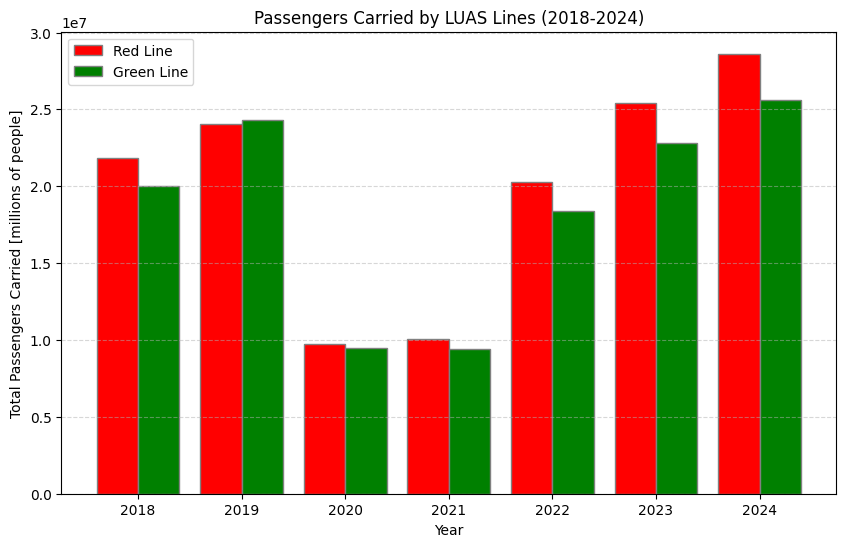

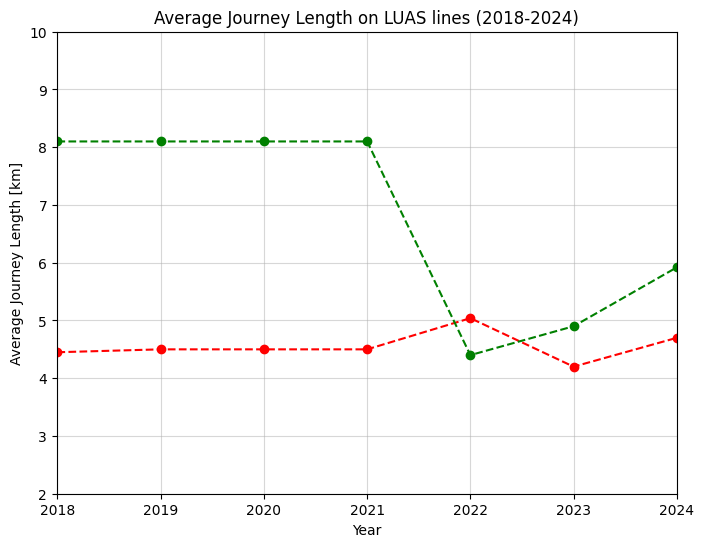

In [ ]:
# SOME PLOTS FOR GENERAL METRICS:

# Prepare data for side-by-side bar plot
# This helper function currently specifically works on a versus year, versus value basis:
def RedGreenBarplots(reddataset, greendataset, yearcol, valcol, barwidth, size, xlabel, ylabel, title):
  years = reddataset[yearcol].values

  # Red and green bar x-positions:
  c1 = np.arange(len(years))
  c2 = [x+barwidth for x in c1]

  plt.figure(figsize=(size))
  plt.bar(c1, reddataset[valcol], color="red", width=barwidth, edgecolor="grey", label="Red Line")
  plt.bar(c2, greendataset[valcol], color="green", width=barwidth, edgecolor="grey",label="Green Line")
  plt.legend()

  plt.xticks([c + barwidth/2 for c in range(len(years))], years)
  plt.grid(axis="y", linestyle="--", alpha=0.5)

  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)

  plt.show()


# Side-by-side bar plotting of the annual ridership trend 2018-2024 for both lines:
RedGreenBarplots(passengers_per_annum_red, passengers_per_annum_green, "Year", "Value", 0.4, (10,6), "Year", "Total Passengers Carried [millions of people]",
                 "Passengers Carried by LUAS Lines (2018-2024)")

# Average Journey Length Plottings

plt.figure(figsize=(8,6))
plt.title("Average Journey Length on LUAS lines (2018-2024)")
plt.plot(avg_journey_length_red["Year"],avg_journey_length_red["Value"],"o--",color="r")
plt.plot(avg_journey_length_green["Year"],avg_journey_length_green["Value"],"o--",color="g")
plt.ylim(2,10)
plt.xlim(2017.995,2024.0005)
plt.xlabel("Year")
plt.ylabel("Average Journey Length [km]")
plt.grid(alpha=0.5)
plt.show()

In [ ]:
# NEW COLUMN: LOAD FACTOR - THE RATIO OF ANNUAL RIDERSHIP WITH THEORETICAL ANNUAL CAPACITY/CAPACBILITY ... [Passengers carried] / (Theoretical annual capacity (const.) )

import math



#THEORETICAL ANNUAL CAPACITY PARAMETER/CONSTANT:




# Assuming max(TOTAL VEHICLE RUNS) is near the physical limit for the amount of services LUAS can run without propagating severe knock-on delays, the
# theoretical annual passenger bandwidth of each line is this limit multiplied by the maximum tram model passenger capacity. max(TOTAL VEHICLE RUNS) * max(VEHICLE CAPACITY)

# Then divide the passengers carried (by line, by year) by this metric (by line).

df.loc[(df["Metric"]=="Length of line") & (df["Year"].isin([2019, 2020])) & (df["Line"]=="Green line"), "Value"]

# Find Green line passenger bandwidth:

total_vehicle_runs_rows_green = df.loc[(df["Metric"]=="Total vehicle runs") & (df["Line"]=="Green line"), "Value"]
tram_capacity_rows_green = df.loc[(df["Metric"]=="Capacity of tram") & (df["Line"]=="Green line"), "Value"]

vehicle_bandwidth_green = np.max(total_vehicle_runs_rows_green)
max_tram_capacity_green = np.max(tram_capacity_rows_green)

passenger_bandwidth_green = vehicle_bandwidth_green * max_tram_capacity_green

print("GREEN line passenger bandwidth:")
print(passenger_bandwidth_green)
print("\n")

# Find Red line passenger bandwidth:

total_vehicle_runs_rows_red = df.loc[(df["Metric"]=="Total vehicle runs") & (df["Line"]=="Red line"), "Value"]
tram_capacity_rows_red = df.loc[(df["Metric"]=="Capacity of tram") & (df["Line"]=="Red line"), "Value"]

vehicle_bandwidth_red = np.max(total_vehicle_runs_rows_red)
max_tram_capacity_red = np.max(tram_capacity_rows_red)

passenger_bandwidth_red = vehicle_bandwidth_red * max_tram_capacity_red

print("RED line passenger bandwidth:")
print(passenger_bandwidth_red)












#LOAD FACTOR:


new_rows = []

for year in df["Year"].unique():
  for line in df["Line"].unique():
    passengers_carried_value = df[(df["Metric"] == "Passengers carried") & (df["Year"] == year) & (df["Line"] == line)]["Value"].values[0]

    bandwidth = 1 #filler

    if line == "Red line":
      bandwidth = passenger_bandwidth_red
    elif line == "Green line":
      bandwidth = passenger_bandwidth_green

    load_factor = 100*(passengers_carried_value/bandwidth) # [people/people] => scalar but not really Number, so will *100 and use as %..."Unit":"Percentage"
    new_rows.append({"Metric": "Load factor", "Year": year, "Line":line, "Unit":"Percentage", "Value":load_factor})

# New dataframe using these rows
df_load_factor = pd.DataFrame(new_rows)

# Concatenate df with this helper dataframe
df = pd.concat([df, df_load_factor], ignore_index=True)

# Resort to keep consistent order
df = df.sort_values(by=["Year", "Line", "Metric"], ascending=[False, True, True], ignore_index=True)

print("\n")
print("Showing/verifying all of the load factor percentages are obtained:")
print("\n")
print(df[df["Metric"] == "Load factor"].head(20))

GREEN line passenger bandwidth:
35449264.0


RED line passenger bandwidth:
33302331.0


Showing/verifying all of the load factor percentages are obtained:


          Metric  Year        Line        Unit      Value
7    Load factor  2024  Green line  Percentage  72.235353
21   Load factor  2024    Red line  Percentage  85.942026
35   Load factor  2023  Green line  Percentage  64.351271
49   Load factor  2023    Red line  Percentage  76.250413
63   Load factor  2022  Green line  Percentage  51.884857
77   Load factor  2022    Red line  Percentage  60.881849
91   Load factor  2021  Green line  Percentage  26.632499
105  Load factor  2021    Red line  Percentage  30.148920
119  Load factor  2020  Green line  Percentage  26.654627
133  Load factor  2020    Red line  Percentage  29.208727
147  Load factor  2019  Green line  Percentage  68.552868
161  Load factor  2019    Red line  Percentage  72.204387
175  Load factor  2018  Green line  Percentage  56.417814
189  Load factor  2018    Red l

Total Red line mileage pear year: [km]


     Year      Value
195  2018  2119703.0
167  2019  2380373.0
139  2020  2318838.0
111  2021  2106265.0
83   2022  2102745.0
55   2023  2255297.0
27   2024  2306241.0


Total Green line mileage per year: [km]


     Year      Value
181  2018  1945776.0
153  2019  1940386.0
125  2020  2003437.0
97   2021  2057609.0
69   2022  2125035.0
41   2023  2059338.0
13   2024  2090733.0


Total Red line length pear year: [km]


     Year  Value
187  2018   20.5
159  2019   20.8
131  2020   20.8
103  2021   20.8
75   2022   20.8
47   2023   20.8
19   2024   20.8


Total Green line length per year: [km]


     Year  Value
173  2018   22.0
145  2019   22.0
117  2020   22.0
89   2021   22.0
61   2022   22.0
33   2023   22.0
5    2024   22.0


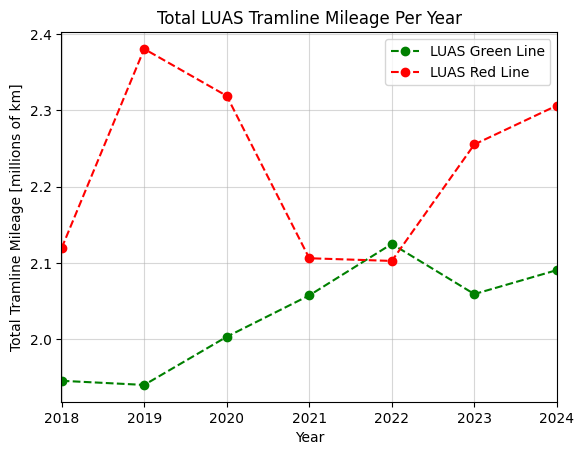

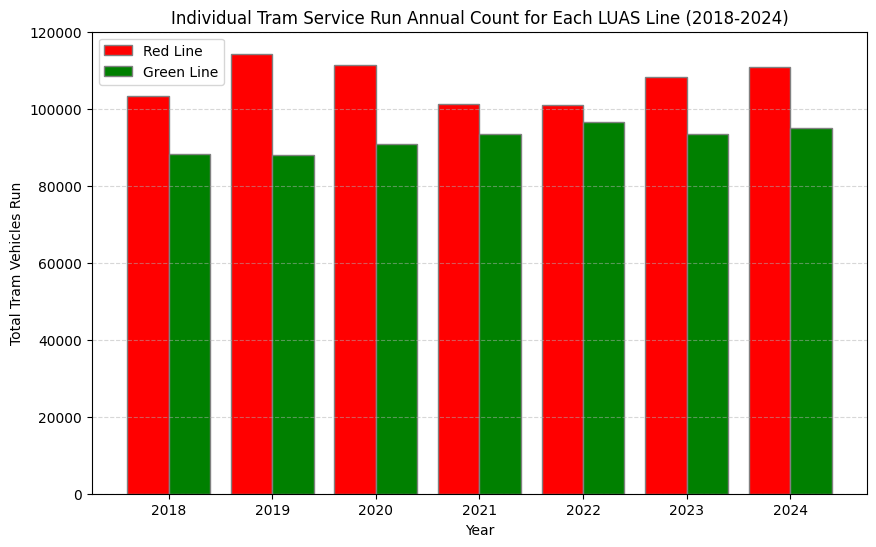

Total vehicle runs Red Line:
     Year     Value
193  2018  103400.0
165  2019  114441.0
137  2020  111482.0
109  2021  101262.0
81   2022  101093.0
53   2023  108427.0
25   2024  110876.0


Total vehicle runs Green Line:
     Year    Value
179  2018  88444.0
151  2019  88199.0
123  2020  91065.0
95   2021  93527.0
67   2022  96592.0
39   2023  93606.0
11   2024  95033.0


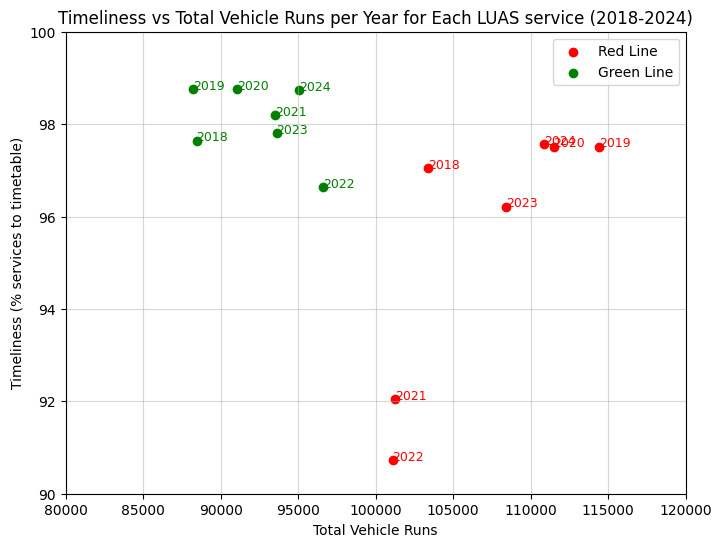

Red line Pearson correlation:  0.811 p-value:  0.027
Green line Pearson correlation:  -0.431 p-value:  0.027


In [ ]:
# MORE SPECIFIC METRICS FOR PROBLEM 2 - LUAS BANDWIDTH

# Total tram-vehicle mileage:
vehicle_km_red = df.loc[(df["Metric"]=="Vehicle kilometres") & (df["Line"]=="Red line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)
vehicle_km_green = df.loc[(df["Metric"]=="Vehicle kilometres") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)
print("Total Red line mileage pear year: [km]")
print("\n")
print(vehicle_km_red)
print("\n")
print("Total Green line mileage per year: [km]")
print("\n")
print(vehicle_km_green)
print("\n")

# Length of each line over the years:
line_length_red = df.loc[(df["Metric"]=="Length of line") & (df["Line"]=="Red line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)
line_length_green = df.loc[(df["Metric"]=="Length of line") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)

print("Total Red line length pear year: [km]")
print("\n")
print(line_length_red)
print("\n")
print("Total Green line length per year: [km]")
print("\n")
print(line_length_green)


plt.title("Total LUAS Tramline Mileage Per Year")
plt.plot(vehicle_km_green["Year"], vehicle_km_green["Value"]/1e6,"o--",color="g",label="LUAS Green Line")
plt.plot(vehicle_km_red["Year"], vehicle_km_red["Value"]/1e6,"o--",color="r", label="LUAS Red Line")
plt.legend()
plt.xlim(2017.995, 2024.005)
plt.xlabel("Year")
plt.ylabel("Total Tramline Mileage [millions of km]")
plt.grid(alpha=0.5)
plt.show()

# Total tram vehicles run per year:
total_vehicle_runs_red = df.loc[(df["Metric"]=="Total vehicle runs") & (df["Line"]=="Red line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)
total_vehicle_runs_green = df.loc[(df["Metric"]=="Total vehicle runs") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)

# Side-by-side bar plotting of the annual ridership trend 2018-2024 for both lines:
RedGreenBarplots(total_vehicle_runs_red, total_vehicle_runs_green, "Year", "Value", 0.4, (10,6), "Year", "Total Tram Vehicles Run",
                 "Individual Tram Service Run Annual Count for Each LUAS Line (2018-2024)")

print("Total vehicle runs Red Line:")
print(total_vehicle_runs_red)
print("\n")
print("Total vehicle runs Green Line:")
print(total_vehicle_runs_green)


# Analyse how timeliness relates to vehicle runs:


from scipy.stats import pearsonr

plt.figure(figsize=(8,6))
plt.scatter(total_vehicle_runs_red["Value"], timeliness_red["Value"],color="r",label="Red Line")
plt.scatter(total_vehicle_runs_green["Value"],timeliness_green["Value"],color="g",label="Green Line")

# Iterate through each row to add the respective year label

for _, row in total_vehicle_runs_red.iterrows():
    x, year = row["Value"], row["Year"]
    y = timeliness_red[timeliness_red["Year"]==year]["Value"].values[0] # first val from series
    plt.text(x,y, int(year), color="r", fontsize=9) # adjust font size .. some years text overlap

for _, row in total_vehicle_runs_green.iterrows():
    x, year = row["Value"], row["Year"]
    y = timeliness_green[timeliness_green["Year"]==year]["Value"].values[0]
    plt.text(x,y, int(year), color="g", fontsize=9)

plt.ylim(90,100)
plt.xlim(80e3,120e3)
plt.xlabel("Total Vehicle Runs")
plt.ylabel("Timeliness (% services to timetable)")
plt.title("Timeliness vs Total Vehicle Runs per Year for Each LUAS service (2018-2024)")
plt.grid(alpha=0.5)
plt.legend()
plt.show()


# Red line correlation
servicetime_corr_red, servicetime_p_red = pearsonr(total_vehicle_runs_red["Value"],timeliness_red["Value"])

# Green line correlation
servicetime_corr_green, servicetime_p_green = pearsonr(total_vehicle_runs_green["Value"],timeliness_green["Value"])

print("Red line Pearson correlation: ",round(servicetime_corr_red,3), "p-value: ",round(servicetime_p_red,3))
print("Green line Pearson correlation: ",round(servicetime_corr_green,3), "p-value: ",round(servicetime_p_red,3))


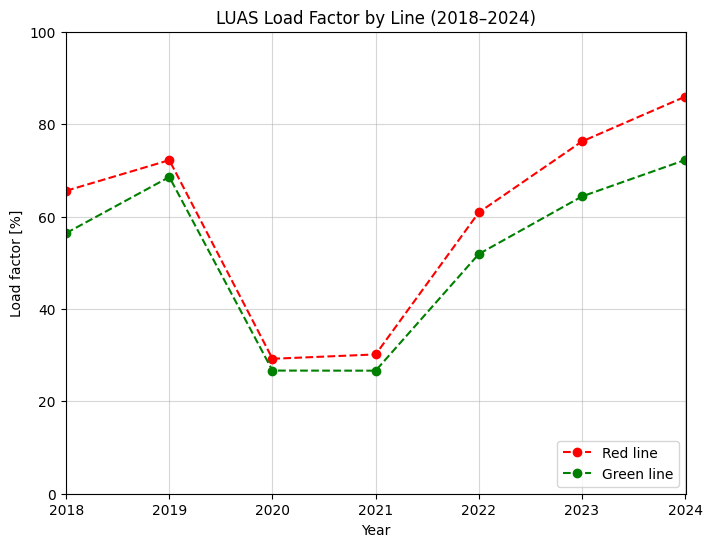

In [ ]:
# VISUALISE THE ANNUAL LOAD FACTOR ATTAINED EACH YEAR FOR EACH LINE


load_factor_red = df.loc[(df["Metric"]=="Load factor") & (df["Line"]=="Red line"),["Year","Value"]].sort_values(by="Year", ascending=True)

load_factor_green = df.loc[(df["Metric"]=="Load factor") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by="Year", ascending=True)

plt.figure(figsize=(8, 6))
plt.plot(load_factor_red["Year"], load_factor_red["Value"], "o--", color="r", label="Red line")
plt.plot(load_factor_green["Year"], load_factor_green["Value"], "o--",color="g", label="Green line")
plt.legend(loc="lower right")
plt.xlabel("Year")
plt.ylabel("Load factor [%]")
plt.ylim(0,100)
plt.title("LUAS Load Factor by Line (2018–2024)")
plt.xlim(2017.995, 2024.005)
plt.grid(alpha=0.5)
plt.show()


Red line Pearson correlation:  0.311 p-value:  0.497
Green line Pearson correlation:  -0.038 p-value:  0.935
Red line Pearson correlation (EXCL.2020,2021):  0.71 p-value:  0.179
Green line Pearson correlation (EXCL.2020,2021):  -0.138 p-value:  0.824


... All rounded to 3 significant figures


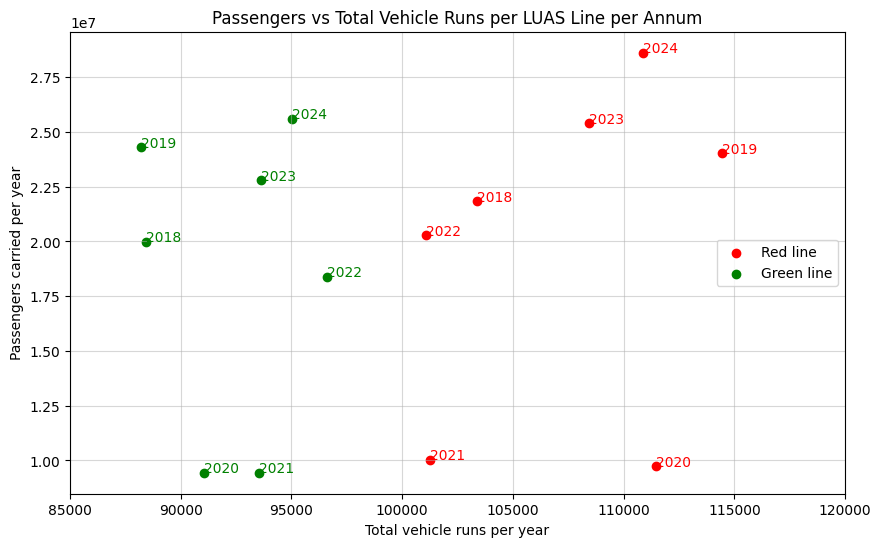

In [ ]:
# RELATIONSHIP BETWEEN TOTAL VEHICLES RUN AND PASSENGER UPTAKE

# Merge runs and passengers for every year for each line

vehicles_passengers_red = pd.merge(total_vehicle_runs_red.rename(columns={"Value":"Vehicle runs"}),
                      passengers_per_annum_red.rename(columns={"Value":"Total passengers"}), on="Year")

vehicles_passengers_green = pd.merge(total_vehicle_runs_green.rename(columns={"Value":"Vehicle runs"}),
                        passengers_per_annum_green.rename(columns={"Value":"Total passengers"}), on="Year")



# Exclude COVID years for secondary pearson correlation score later:
vehicles_passengers_excl_covid_red = vehicles_passengers_red.loc[(~vehicles_passengers_red["Year"].isin([2020,2021]))]
vehicles_passengers_excl_covid_green = vehicles_passengers_green.loc[(~vehicles_passengers_green["Year"].isin([2020,2021]))]

from scipy.stats import pearsonr

# Red line correlation
corr_red, p_red = pearsonr(vehicles_passengers_red["Vehicle runs"],vehicles_passengers_red["Total passengers"])

# Green line correlation
corr_green, p_green = pearsonr(vehicles_passengers_green["Vehicle runs"], vehicles_passengers_green["Total passengers"])

print("Red line Pearson correlation: ",round(corr_red,3), "p-value: ",round(p_red,3))
print("Green line Pearson correlation: ",round(corr_green,3), "p-value: ",round(p_green,3))

# Red line correlation (excluding 2020,2021)
corr_excl_red, p_excl_red = pearsonr(vehicles_passengers_excl_covid_red["Vehicle runs"],
                                     vehicles_passengers_excl_covid_red["Total passengers"])

# Green line correlation (excluding 2020,2021)
corr_excl_green, p_excl_green = pearsonr(vehicles_passengers_excl_covid_green["Vehicle runs"],
                                     vehicles_passengers_excl_covid_green["Total passengers"])

print("Red line Pearson correlation (EXCL.2020,2021): ",round(corr_excl_red,3),"p-value: ",round(p_excl_red,3))
print("Green line Pearson correlation (EXCL.2020,2021): ",round(corr_excl_green,3), "p-value: ",round(p_excl_green,3))
print("\n")
print("... All rounded to 3 significant figures")
# SHOWS THAT RED LINE - RUNNING MORE VEHICLES HAS INCREASED THE PASSENGERS CARRIED

# SHOWS THAT GREEN LINE - WHILE INCREASING VEHICLE RUNS HAS NOT NECESSARILY CONTRIBUTED TO FURTHER UPTAKE


plt.figure(figsize=(10, 6))
plt.title("Passengers vs Total Vehicle Runs per LUAS Line per Annum")
plt.scatter(vehicles_passengers_red["Vehicle runs"], vehicles_passengers_red["Total passengers"], color="r", label="Red line")
plt.scatter(vehicles_passengers_green["Vehicle runs"], vehicles_passengers_green["Total passengers"], color="g", label="Green line")
plt.legend(loc="center right")

# Iterate through each row to add the respective year label
for _, row in vehicles_passengers_red.iterrows():
    plt.text(row["Vehicle runs"], row["Total passengers"], int(row["Year"]), color="r", fontsize=10) #larger fontsize looks better
for _, row in vehicles_passengers_green.iterrows():
    plt.text(row["Vehicle runs"], row["Total passengers"], int(row["Year"]), color="g", fontsize=10)

plt.grid(alpha=0.5)
plt.xlabel("Total vehicle runs per year")
plt.ylabel("Passengers carried per year")
plt.xlim(85000,120000)
plt.show()


/tmp/ipython-input-2310382147.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot = plt.boxplot([passengers_per_run_red["Value"].values,passengers_per_run_green["Value"].values], labels=["Red line","Green line"],


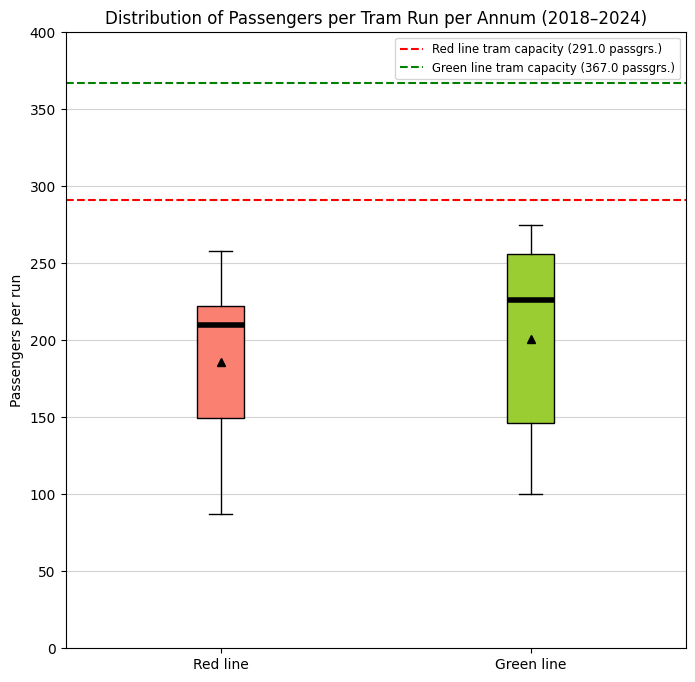

In [ ]:
# BOXPLOT THE DISTRUBTION OF PASSENGERS PER SERVICE
# NOT INCLUDED IN REPORT AS IT IS NOT STRICTLY INDICATIVE OF ANY MEANINGFUL
# INFORMATION SINCE THESE ARE ANNUAL REPORTS, NOT BY SERVICE

passengers_per_run_red = df.loc[(df["Metric"]=="Average passengers per run") & (df["Line"]=="Red line"), ["Year","Value"]].sort_values(by="Year", ascending=True)
passengers_per_run_green = df.loc[(df["Metric"]=="Average passengers per run") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by="Year", ascending=True)


plt.figure(figsize=(8,8))

boxplot = plt.boxplot([passengers_per_run_red["Value"].values,passengers_per_run_green["Value"].values], labels=["Red line","Green line"],
                      showmeans=True, patch_artist=True) #patch_artist allows colour coding)

# Colour code the boxes:
for patch, colour in zip(boxplot["boxes"], ["salmon","yellowgreen"]): #salmon and yellowgreen aren't too strong
    patch.set_facecolor(colour)

# Blacken the mean and median markers:
for median in boxplot["medians"]:
    median.set_color("k")
    median.set_linewidth(4) #keep thicker so its more visible
for mean in boxplot["means"]:
    mean.set_markerfacecolor("k")
    mean.set_markeredgecolor("k")

# Capacity of each line graduation mark

plt.axhline(max_tram_capacity_red, color="red",label=f"Red line tram capacity ({max_tram_capacity_red} passgrs.)", linestyle="--", )
plt.axhline(max_tram_capacity_green, color="green",label=f"Green line tram capacity ({max_tram_capacity_green} passgrs.)", linestyle="--", )

plt.ylabel("Passengers per run")
plt.grid(axis="y",alpha=0.55)
plt.legend(fontsize="small")
plt.title("Distribution of Passengers per Tram Run per Annum (2018–2024)")
plt.ylim(0,400)
plt.show()


#Geographical visualisation

In [ ]:
print(np.unique(df["Metric"]))

['Average length of journey' 'Average number of stops per passenger'
 'Average passengers per run' 'Capacity of tram' 'Journey time'
 'Length of line' 'Length of tram' 'Load factor' 'Passenger kilometres'
 'Passengers carried' 'Timeliness (% services to timetable)'
 'Total vehicle runs' 'Trams' 'Vehicle kilometres']


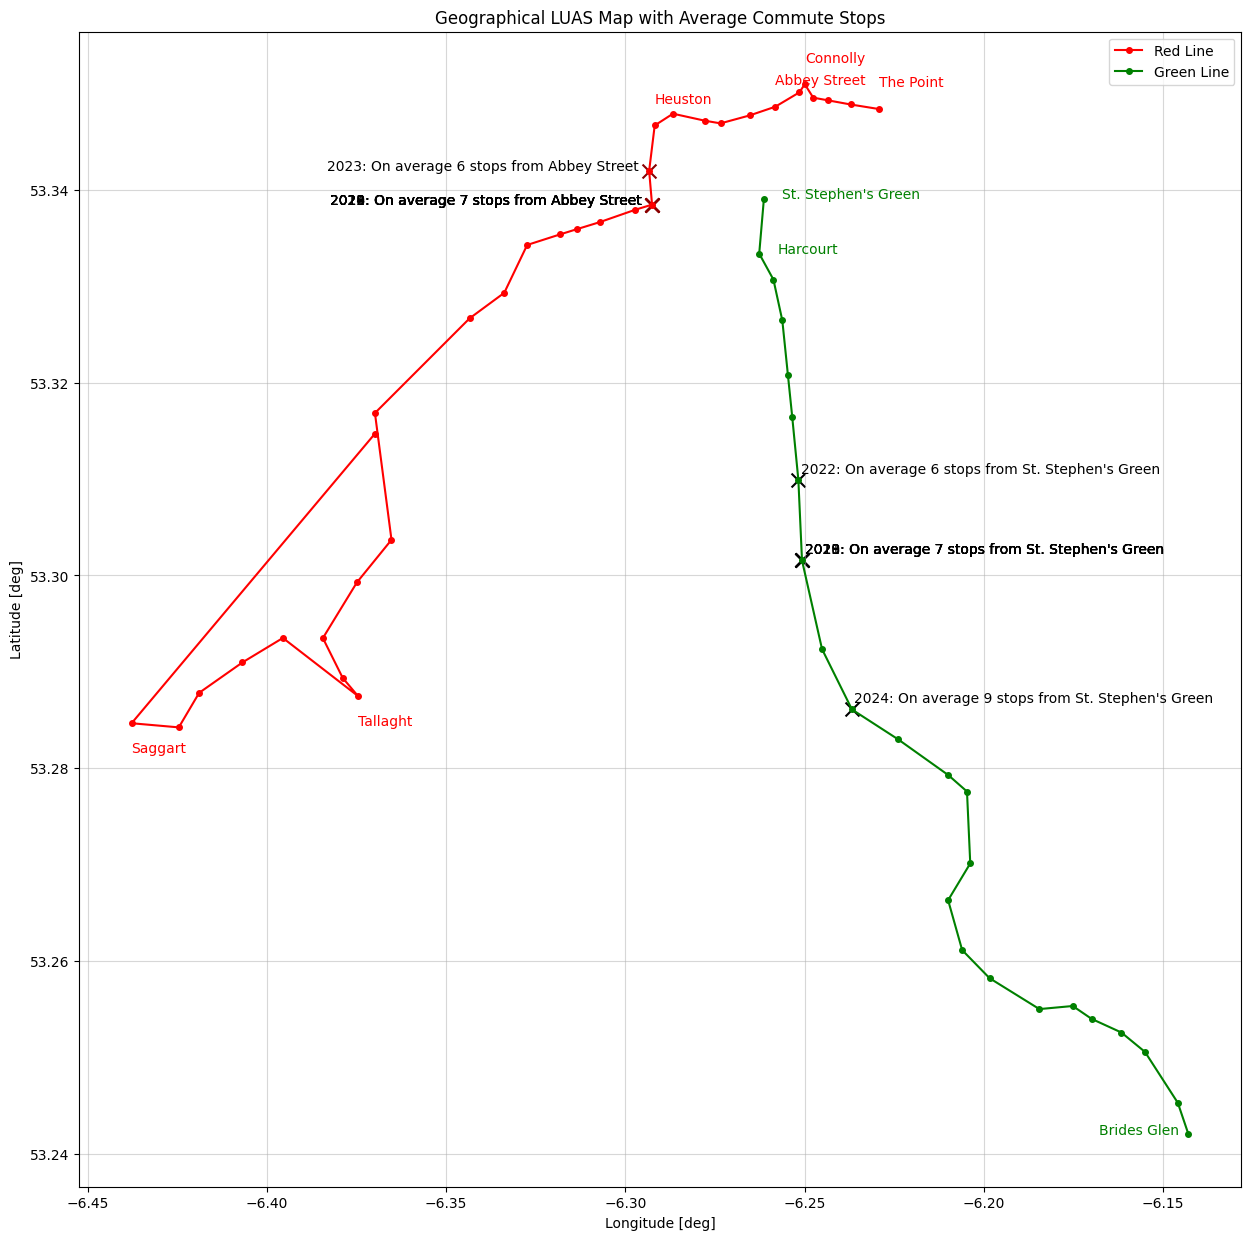

     Year  Value
156  2018   8.10
130  2019   8.10
104  2020   8.10
78   2021   8.10
52   2022   4.40
26   2023   4.90
0    2024   5.92


In [ ]:
# To geographically visaulise, will use an outdated LUAS map (green: Stephens Green-Bride's Glen)
# no recent geolocation dataset could be found. this was taken from
# data.tii.ie
# https://data.tii.ie/Datasets/Luas/StopLocations/luas-stops.txt

import math

# Read the location dataset .txt file
stops = pd.read_csv("luas-stops.txt", sep="\t") #reads as csv; Red Line = LineID 1, Green Line = LineID 2
red = stops[stops["LineID"]==1].sort_values("SortOrder") #this stops a weird webbing pattern of the red line stops
green = stops[stops["LineID"]==2]

# Coordinates (x,y) -> (long,lat):
red_x = red["Longitude"].values
red_y = red["Latitude"].values
green_x = green["Longitude"].values
green_y = green["Latitude"].values


plt.figure(figsize=(15,15))

# Plot up the stations and a rough rail line track:
plt.plot(red_x, red_y, "o-",color="red", markersize=4, label="Red Line")
plt.plot(green_x, green_y,  "o-", color="green", markersize=4, label="Green Line")


# plt.text() major and end stops:
# Will have to shimmy the text as needed due to it overlapping with the line (this was done by visual inspection)

# Red labels:
for _, row in red.iterrows():
  if row["Name"] in ["Heuston", "Connolly", "Abbey Street", "The Point"]:
    plt.text(row["Longitude"], row["Latitude"]+0.0023, row["Name"],color="r",fontsize=10)
  if row["Name"] in ["Tallaght", "Saggart"]:
    plt.text(row["Longitude"], row["Latitude"]-0.003, row["Name"], color="r",fontsize=10)

# Green labels:
for _, row in green.iterrows():
  if row["Name"] in ["Brides Glen"]:
    plt.text(row["Longitude"]-0.025, row["Latitude"], row["Name"],fontsize=10,color="g")
  if row["Name"] in ["St. Stephen's Green","Harcourt"]:
    plt.text(row["Longitude"]+0.005, row["Latitude"], row["Name"],fontsize=10, color="g")



# VISUALISE THE AVG NUMBER OF STOPS ... CHOOSE FROM BUSY STATIONS IN THE HOME COMMUTE DIRECTION
# will pick St. Stephen's Green for the Green line, and Abbey Street for the Red Line
# this will visualise the daily commute load, which is the baseline on top of additional demand for multievents

# GREEN LINE:

# Average stop extraction:
avg_stops_green = df.loc[(df["Metric"]=="Average number of stops per passenger") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)
#line_length_green = df.loc[(df["Metric"]=="Length of line") & (df["Line"]=="Green line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)

# Order the green line in the commuter direction (towards Brides Glen)
green_ordered = stops[stops["LineID"] == 2].sort_values("SortOrder").reset_index(drop=True)
# Stephens green index is just zero. its the first one
stephens_green_index = 0
# Splice the line (though it doesnt matter since this is the whole line, I originally picked Harcourt so leaving this intact if I want to change again)
sg_to_bg = green_ordered.loc[stephens_green_index:].reset_index(drop=True)

# Mark the avg. no. of stops per year on the spliced line:
for _, row in avg_stops_green.iterrows():
  year = int(row["Year"])
  n_stops = int(row["Value"]) # the target number of stops. 0 is stephens green, 1 harcourt, etc
  n_stops = math.ceil(n_stops) # round up.. an average of 2.3 stops is 3 stops

  stop_row = sg_to_bg.iloc[n_stops]
  x = stop_row["Longitude"]
  y = stop_row["Latitude"]

  # Plot the average stops with an X maybe?
  plt.scatter(x, y, marker="x", s=100, color="black")

  # TODO: implement a way to stop the text of coindicent avg stops from overlapping
  stops_tracking = {}
  count = stops_tracking.get(n_stops, 0)

  # Label slightly offset so it doesn't overlap
  plt.text( x + 0.0007, y + 0.0007, f"{year}: On average {n_stops} stops from St. Stephen's Green", fontsize=10, color="black" )

# RED LINE:

# Average stop extraction:
avg_stops_red = df.loc[(df["Metric"]=="Average number of stops per passenger") & (df["Line"]=="Red line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)
#line_length_red = df.loc[(df["Metric"]=="Length of line") & (df["Line"]=="Red line"), ["Year","Value"]].sort_values(by=["Year"],ascending=True)

# Order the red line in the commuter direction (towards Brides Glen)
red_ordered = stops[stops["LineID"] == 1].sort_values("SortOrder").reset_index(drop=True)
# Abbey St index is:
abbey_street_index = red_ordered.index[red_ordered["Name"] == "Abbey Street"][0]
# Splice the line (though it doesnt matter since this is the whole line, I originally picked Harcourt so leaving this intact if I want to change again)
ab_outbound = red_ordered.loc[abbey_street_index:].reset_index(drop=True)

# Mark the avg. no. of stops per year on the spliced line:
for _, row in avg_stops_red.iterrows():
  year = int(row["Year"])
  n_stops = int(row["Value"]) # the target number of stops. 0 is abbey st, 1 jervis, etc.
  n_stops = math.ceil(n_stops) # round up.. an average of 2.3 stops is 3 stops

  stop_row = ab_outbound.iloc[n_stops]
  x = stop_row["Longitude"]
  y = stop_row["Latitude"]

  # Plot the average stops with an X maybe?
  plt.scatter(x, y, marker="x", s=100, color="darkred")

  # TODO: implement a way to stop the text of coindicent avg stops from overlapping
  stops_tracking = {}
  count = stops_tracking.get(n_stops, 0)

  # Label slightly offset so it doesn't overlap
  plt.text(x-0.09,y, f"{year}: On average {n_stops} stops from Abbey Street", fontsize=10, color="black" )


plt.title("Geographical LUAS Map with Average Commute Stops")
plt.xlabel("Longitude [deg]")
plt.ylabel("Latitude [deg]")
plt.legend()
plt.grid(alpha=0.5)
plt.show()

print(avg_journey_length_green)
